#### 1- Set up the envionment 

In [78]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats
from scipy.stats import norm
import pandas_datareader as pdr
from matplotlib import rcParams 
rcParams['figure.figsize']  = 8, 6

#### 2 - Download the stock price data, store in dataframe


In [55]:
##amzn = pdr.get_data_yahoo('AMZN')
amzn = pd.read_csv('AMZN.csv', parse_dates = ['Date'])

In [56]:
amzn['Date'] = pd.to_datetime(amzn['Date'])
amzn = amzn.sort_values('Date', ascending = False)

In [57]:
## take a look
amzn = amzn.set_index("Date")
amzn.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-03,105.260002,108.779999,102.519997,103.389999,103.389999,144173400
2023-02-02,110.250000,114.000000,108.879997,112.910004,112.910004,158154200
2023-02-01,102.529999,106.239998,101.239998,105.150002,105.150002,80450100
2023-01-31,101.160004,103.349998,101.139999,103.129997,103.129997,66527300
2023-01-30,101.089996,101.739998,99.010002,100.550003,100.550003,70691900


#### 3- Store instantanous rate of return in seperate series

In [100]:
amzn_close = amzn['Close']
amzn_return = np.log(amzn_close).diff()  # to see the very small difference
amzn_return.head()

Date
2023-02-03         NaN
2023-02-02    0.088083
2023-02-01   -0.071203
2023-01-31   -0.019398
2023-01-30   -0.025335
Name: Close, dtype: float64

Result shows that there was a gain in the first day to to the next day and a loss from the second day to the third and so on

#### 4 - Plot the series

<AxesSubplot:xlabel='Date'>

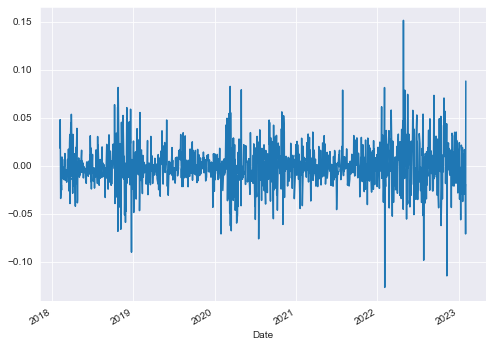

In [65]:
sn.set_style('darkgrid')
amzn_return.plot()

<AxesSubplot:xlabel='Date'>

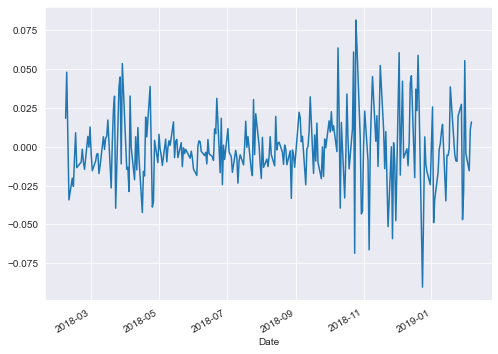

In [67]:
 ## just to check one year data
amzn_return[-252 :].plot()

#### 5 -Pandas describe function gives descriptive stat, default assumes you are dealing with a simple Pandas also deals with missing values by omitting them

In [128]:
amzn_return.dropna(inplace = True)
amzn_return.describe()

count    1257.000000
mean       -0.028679
std         2.286844
min       -12.690000
25%        -1.170000
50%        -0.120000
75%         1.080000
max        15.140000
Name: Close, dtype: float64

#### 6- An alternative more slightly different table of descriptives from scipy stats

In [129]:
stats.describe(amzn_return) ## you need to drop na so as this part to work

DescribeResult(nobs=1257, minmax=(-12.69, 15.14), mean=-0.028679395385839298, variance=5.22965366862766, skewness=0.16119504342453758, kurtosis=4.056581937010496)

In [132]:
## to allow you access
n, minmax, mean, var, skew, kurt = stats.describe(amzn_return)
mini, maxi = minmax ## again unpack that
std = var ** .5

Result shows there is a skewness toward the right as it is postive,  kurtosis indicates there is a normalization

#### 7- For comparison generate random numbers that follow normal distribution

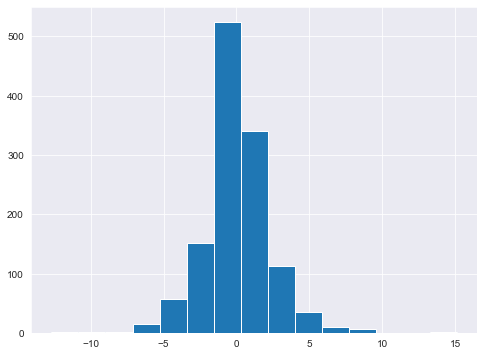

In [106]:
## to rid of the small decimal point and all : round
amzn_return = round(np.log(amzn_close).diff() * 100, 2) # to see the very small difference
plt.hist(amzn_return, bins = 15);

From the result we can see that there is a big move.. normally normal dic ranges from -4 :4 but here there is alot around -5: 5

In [133]:
from scipy.stats import norm 
x = norm.rvs(mean, std, n) ## rvs - random vairable

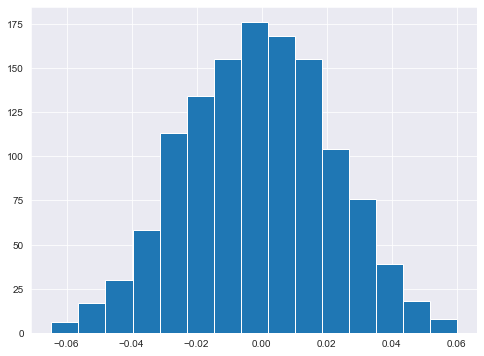

In [111]:
plt.hist(x, bins = 15);

##  Is price change normally distributed?

#### 8 - Use scipy stats to test the kurtosis, the null hypothesis is that the sample is drawn from the population where the underlying kurtoisis is that of a normal distribution variable

In [134]:
x_test = stats.kurtosistest(x)
amzn_test = stats.kurtosistest(amzn_return)
print(f'{"      Test statistic":20}{"P-value":>15}')
print(f'{" " *5}{"-"* 30}')
print(f'x:{x_test[0]:>17.2f}{x_test[1]:16.4f}')
print(f'AMZN: {amzn_test[0]:13.3f}{amzn_test[1]:16.4f}')

      Test statistic        P-value
     ------------------------------
x:             0.45          0.6519
AMZN:        11.087          0.0000


Result shows that the p-value of the amazon data is lesser than 0.5 and this tells that the distribution isn;t random ...so we reject the null!!

> what is x? 
is the sample we got from the return data so as to test..

#### 9 - Plot histagram of price changes with normal curve overlay

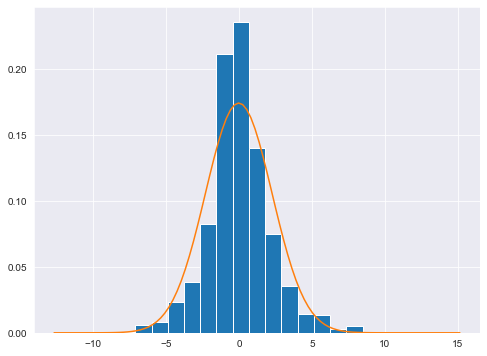

In [138]:
plt.hist(amzn_return, bins = 25,  edgecolor = 'w', density = True );
overlay = np.linspace(mini, maxi, 100)
plt.plot(overlay, norm.pdf(overlay, mean, std)) ## pdf: probability denisty function 

From this result: we can answer the first question if the price changes is normally distributed: we can say NO!

### Is daily price changes significantly different from zero?

#### 10- Conduct simple hypothesis test

In [141]:
stats.ttest_1samp(amzn_return, 0, alternative = 'two-sided')

Ttest_1sampResult(statistic=-0.44463246099508236, pvalue=0.6566619901312765)

Result shows as the p-value is greater than 0.5 we can't reject the Ho and this shows there a biasiness in the price change

In [142]:
stats.ttest_1samp(amzn_return.sample(252), 0, alternative = 'two-sided')

Ttest_1sampResult(statistic=-0.3786503636372903, pvalue=0.7052675956207526)

### Can price movement be described as a random walk

#### 11- Create price lags

In [151]:
amzn_close = pd.DataFrame(amzn_close, columns = ['Close'])
amzn_close['lag_1'] = amzn_close.Close.shift(1) ## offset by one
amzn_close['lag_2'] = amzn_close.Close.shift(2) ## offset by two
amzn_close.dropna(inplace = True) ## drop the NAs
amzn_close.head()

,Close,lag_1,lag_2
Date,,,
2023-01-26,99.220001,102.239998,100.550003
2023-01-25,97.180000,99.220001,102.239998
2023-01-24,96.320000,97.180000,99.220001
2023-01-23,97.519997,96.320000,97.180000
2023-01-20,97.250000,97.519997,96.320000


#### 12 - Fit linear model

In [159]:
lr = np.linalg.lstsq(amzn_close[['lag_1', 'lag_2' ]], amzn_close['Close'], rcond = None)[0]
lr

array([0.98208718, 0.01754193])

Result shows that : the coefficient of Lag1 and 2: and this tell's that -- 98% of tmws price can be predicted from today's and the remaining with the second lag

In [161]:
amzn_close['predict'] = np.dot(amzn_close[['lag_1', 'lag_2' ]], lr )
amzn_close.head()

,Close,lag_1,lag_2,predict
Date,,,,
2023-01-26,99.220001,102.239998,100.550003,102.172432
2023-01-25,97.180000,99.220001,102.239998,99.236178
2023-01-24,96.320000,97.180000,99.220001,97.179742
2023-01-23,97.519997,96.320000,97.180000,96.299362
2023-01-20,97.250000,97.519997,96.320000,97.462778


<AxesSubplot:xlabel='Date'>

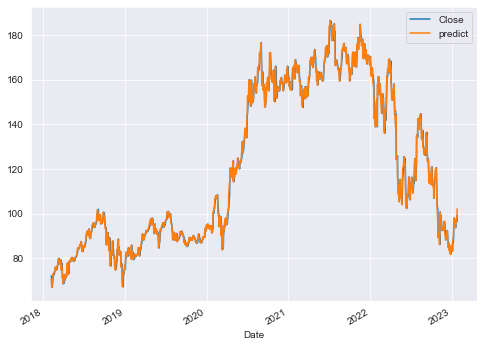

In [162]:
amzn_close[['Close', 'predict']].plot()

<AxesSubplot:xlabel='Date'>

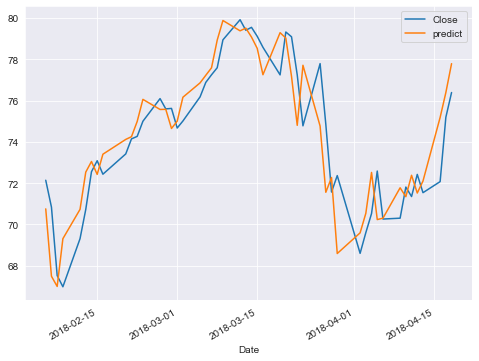

In [173]:
amzn_close.iloc[-50:][['Close', 'predict']].plot() ## to check the last years